<a href="https://colab.research.google.com/github/ting486/Consumer-Reviews-And-Purchasing-Decisions/blob/main/amazon_video_games_25GB_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consumer Reviews Data Analysis

## Notebook Setup

In [1]:
# check available RAM
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        568M         22G        1.2M        2.4G         24G
Swap:            0B          0B          0B


In [153]:
# data source: http://deepyeti.ucsd.edu/jianmo/amazon/index.html
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import time
import re
import statsmodels as sm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download(['vader_lexicon','stopwords'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Initial Data

In [4]:
# get products data
dfProd = pd.read_json('gdrive/MyDrive/amazon_data/meta_Video_Games.json', lines=True)

In [5]:
print(dfProd.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

In [6]:
print(dfProd.head())

                                            category tech1  \
0                           [Video Games, PC, Games]         
1  [Video Games, Xbox 360, Games, </span></span><...         
2  [Video Games, Retro Gaming & Microconsoles, Su...         
3  [Video Games, Xbox 360, Accessories, Controlle...         
4  [Video Games, PC, Games, </span></span></span>...         

                                         description fit  \
0                                                 []       
1                                [Brand new sealed!]       
2                                                 []       
3  [MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...       
4  [Phonics Alive! 3, The Speller teaches student...       

                                               title      also_buy tech2  \
0                         Reversi Sensory Challenger            []         
1  Medal of Honor: Warfighter - Includes Battlefi...  [B00PADROYW]         
2  street fighter 2 II turbo super nin

In [7]:
# get reviews data
dfReviews = pd.read_json("gdrive/MyDrive/amazon_data/Video_Games.json", lines=True)

In [8]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   overall         2565349 non-null  int64 
 1   verified        2565349 non-null  bool  
 2   reviewTime      2565349 non-null  object
 3   reviewerID      2565349 non-null  object
 4   asin            2565349 non-null  object
 5   reviewerName    2565096 non-null  object
 6   reviewText      2563634 non-null  object
 7   summary         2564538 non-null  object
 8   unixReviewTime  2565349 non-null  int64 
 9   vote            442716 non-null   object
 10  style           1319972 non-null  object
 11  image           28305 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 217.7+ MB
None


In [9]:
print(dfReviews.head())

   overall  verified   reviewTime      reviewerID        asin  \
0        1      True   06 9, 2014  A21ROB4YDOZA5P  0439381673   
1        3      True  05 10, 2014  A3TNZ2Q5E7HTHD  0439381673   
2        4      True   02 7, 2014  A1OKRM3QFEATQO  0439381673   
3        1      True   02 7, 2014  A2XO1JFCNEYV3T  0439381673   
4        4      True  01 16, 2014  A19WLPIRHD15TH  0439381673   

       reviewerName                                         reviewText  \
0     Mary M. Clark  I used to play this game years ago and loved i...   
1         Sarabatya  The game itself worked great but the story lin...   
2   Amazon Customer  I had to learn the hard way after ordering thi...   
3  ColoradoPartyof5  The product description should state this clea...   
4    Karen Robinson  I would recommend this learning game for anyon...   

                                             summary  unixReviewTime vote  \
0                                  Did not like this      1402272000  NaN   
1         

## Product Data

### Data Cleaning

In [10]:
lenProdOrig = len(dfProd)
lenProdUnique = len(dfProd['asin'].unique())
print(str(lenProdUnique), 'unique ASIN; ', 
      str(lenProdOrig-lenProdUnique), 'duplicate rows (', 
      "{:5.2f}".format((lenProdOrig-lenProdUnique)/lenProdOrig*100),
      '%) removed from', str(lenProdOrig), 'rows')

71911 unique ASIN;  12908 duplicate rows ( 15.22 %) removed from 84819 rows


In [11]:
# drop duplicates
dfProdDup = dfProd.loc[dfProd.duplicated(['asin'])]
dfProdDup = dfProd.loc[dfProd['asin'].isin(list(dfProdDup['asin']))]
dfProdDup = dfProdDup.sort_values(by='asin')

dfProd = dfProd.drop_duplicates(['asin'], ignore_index=True)

#### Rank

In [12]:
dfProd['rank'] = dfProd['rank'].apply(lambda x: [x] if len(x) > 4 else x)

# split rank from list to separate category level & rank number columns
def rank_mod(s):
  res = [ss.replace(',', '').replace('&amp;', '&').replace('\n', '').replace('\t', '').replace('\\', '').replace('#',
             '').replace('&gt;', '>').lstrip('>').rstrip(' (') for ss in s]
  res = [re.sub(" ([\(\[]).*?([\)\]])", "", r) for r in res]
  res = sorted(res, key=lambda x: x.count('>'))

  res = [item.split(' in ', 1) for item in res]
  res = [item for l in res for item in l]

  return res

dfProd['rank'] = dfProd['rank'].apply(lambda x: rank_mod(x))

In [13]:
dfProdRank = pd.DataFrame(dfProd['rank'].to_list(), columns=['rank1', 'category1', 'rank2', 'category2',
                                                              'rank3', 'category3', 'rank4', 'category4'])
dfProdRank = dfProdRank.merge(dfProd, left_index=True, right_index=True)
dfProdRank = dfProdRank[['rank1', 'category1', 'rank2', 'category2', 'rank3', 'category3', 'rank4', 'category4',
                         'asin', 'title', 'main_cat', 'category']]

In [14]:
# dfProdRank = dfProdRank.loc[dfProdRank['category1'].notna()]
dfProdRank['category1'] = dfProdRank.category1.str.replace(r'^Video Games.*', 'Video Games', regex=True)

dfProdRank['category'] = [','.join(map(str, l)) for l in dfProdRank['category']]
dfProdRank['category'] = dfProdRank.category.str.replace(r'<.*?>', '', regex=True)
dfProdRank['category'] = dfProdRank.category.str.strip(',')

# only use the products that have a rank in Video Games category, for unbiased comparison amongst video game products
dfProdRank = dfProdRank.loc[dfProdRank['category1'] == 'Video Games']

# remove irrelevant products like those under accessories & console subcategories
dfProdRank = dfProdRank.loc[(dfProdRank['main_cat'].isin(['Video Games', 'Sports & Outdoors', ''])) & 
                              (~dfProdRank['category'].str.contains('accessories', case=False))]
dfProdRank = dfProdRank.loc[(~dfProdRank['category2'].str.contains('accessories', case=False, na=False)) & 
                            (~dfProdRank['category3'].str.contains('accessories', case=False, na=False)) &
                            (~dfProdRank['category4'].str.contains('accessories', case=False, na=False))]
dfProdRank = dfProdRank.loc[(~dfProdRank['category2'].str.contains('console', case=False, na=False)) & 
                            (~dfProdRank['category3'].str.contains('console', case=False, na=False)) &
                            (~dfProdRank['category4'].str.contains('console', case=False, na=False))]

In [15]:
# remove products w/out any reviews
dfProdRank = dfProdRank.loc[dfProdRank['asin'].isin(dfReviews['asin'].unique())]

In [16]:
lenProdClean = len(dfProdRank)
print('Removing duplicate rows, accessory products, console products, products without a rank at',
      'Video Games category, \nand products without a single review have in total removed',
      str(lenProdOrig - lenProdClean), 'rows (', 
      '{:5.2f}'.format((lenProdOrig - lenProdClean)/lenProdOrig*100), '%) from the original', 
      str(lenProdOrig), 'rows of data, \nleaving',
      str(lenProdClean), 'data points remaining for analysis')

Removing duplicate rows, accessory products, console products, products without a rank at Video Games category, 
and products without a single review have in total removed 44829 rows ( 52.85 %) from the original 84819 rows of data, 
leaving 39990 data points remaining for analysis


In [17]:
# merge rank info into original product data
dfProd = dfProd.merge(dfProdRank, how='inner', on='asin', suffixes=('', '_y'))

dfProd = dfProd.astype({'rank1': 'float64', 'rank2': 'float64', 'rank3': 'float64', 'rank4': 'float64'})
dfProd = dfProd.astype({'rank1': 'Int64', 'rank2': 'Int64', 'rank3': 'Int64', 'rank4': 'Int64'})

#### Brand

In [18]:
dfProd['brand'] = dfProd['brand'].str.replace('by\n', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('\n', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('by ', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('.', '', regex=False)
dfProd['brand'] = dfProd['brand'].str.lstrip()

In [19]:
dfProd['brand'] = dfProd['brand'].replace({'EA': 'Electronic Arts', 'EA Games': 'Electronic Arts', 'At Electronic Arts': 'Electronic Arts',
                         'Electronic Arts Sports': 'EA Sports', 'Electronic Arts, Inc.': 'Electronic Arts',
                         'Electronic Arts Inc': 'Electronic Arts', 'Electronic Arts 1001573': 'EA Sports',
                         'EA Active': 'EA Sports', 'Electronic Arts UK IMPORT': 'EA Sports'})
dfProd['brand'] = dfProd['brand'].replace({'HPS Simulation': 'HPS Simulations'})
dfProd['brand'] = dfProd['brand'].replace({'PS1': 'Playstation', 'PS2': 'Playstation', 'PS3': 'Playstation', 'PS4': 'Playstation'})
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS2.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS 2.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS3.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS 3.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS4.*$)', 'Playstation', regex=True)

dfProd['brand'] = dfProd['brand'].replace({'': np.nan, 'Unknown': np.nan}, regex=True)

In [ ]:
# dfProd[['brand', 'title']].loc[dfProd['brand'].str.contains('xbox', case=False, na=False)].sort_values(by='brand')

In [ ]:
# dfProdBrand = dfProd['brand'].value_counts(dropna=False).reset_index()
# dfProdBrand

#### Price

In [20]:
# convert price to float dtype
def convert_float(x):
    try:
        return float(x)
    except:
        return np.nan
dfProd['price'] = dfProd['price'].str.replace('$', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace(',', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace(r'<.*?>', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace('\n', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace('\t', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace(' ', '', regex=True)
dfProd['price'] = dfProd['price'].apply(lambda p: convert_float(p))

In [21]:
lenProdValidPrice = dfProd['price'].notna().sum()
print(str(lenProdValidPrice), 'products have a valid price')

6632 products have a valid price


### Data Manipulation

In [22]:
# count number of images & high resolution images
dfProd['NumImages'] = dfProd['imageURL'].str.len()
dfProd['NumHighResImages'] = dfProd['imageURLHighRes'].str.len()

In [23]:
dfProd['Feature'] = dfProd.feature.apply(lambda x: ', '.join([str(i) for i in x]))
dfProd['Feature'] = dfProd.Feature.str.replace(r'<.*?>', '', regex=True)
dfProd['LenFeature'] = dfProd['Feature'].str.len()

In [24]:
dfProd['Description'] = dfProd.description.apply(lambda x: ', '.join([str(i) for i in x]))
dfProd['Description'] = dfProd.Description.str.replace(r'<.*?>', '', regex=True)
dfProd['LenDescription'] = dfProd['Description'].str.len()

In [25]:
# extract detail keys
dfProdDetails = dfProd.loc[(~dfProd['details'].isna()) & (dfProd['details'].str.len() > 0)]
dfProdDetails = dfProdDetails[['details']]

dfProdDetails['details'] = [list(d.keys()) for d in dfProdDetails['details']]
dfProdDetails['details'] = dfProdDetails.details.apply(lambda x: ', '.join([str(i) for i in x]))
dfProdDetails['details'] = dfProdDetails['details'].replace({':': '', '\n': '', ' ': ''}, regex=True)

dfProd = dfProd.merge(dfProdDetails, how='left', left_index=True, right_index=True)

In [26]:
dfProd['NumDetails'] = dfProd['details_x'].str.len()
dfProd['NumDetails'] = dfProd['NumDetails'].fillna(0)

In [27]:
dfProd['category_y'] = dfProd.category_y.str.replace(r'<.*?>', '', regex=True)
dfProd['category_y'] = dfProd['category_y'].str.strip(',')

In [28]:
# final touch-up
dfProd = dfProd.astype({'NumImages': np.uint8, 'NumHighResImages': np.uint8, 'NumDetails': np.uint8})
dfProd = dfProd[['asin', 'title', 'brand', 'main_cat', 'category_y', 'price',
                 'rank1', 'rank2', 'category2', 'rank3', 'category3', 'rank4', 'category4',
                 'NumImages', 'NumHighResImages', 'details_y', 'NumDetails',
                 'Feature', 'LenFeature', 'Description', 'LenDescription' #, 'also_buy', 'also_view', 'similar_item'
                 ]]
dfProd = dfProd.rename(columns={'asin': 'Asin', 'title': 'Title', 'brand': 'Brand', 
                                'main_cat': 'MainCategory', 'category_y': 'Categories', 'price': 'Price', 
                                'rank1': 'RankVideoGames', 'rank2': 'RankCategory2', 'category2': 'Category2',
                                'rank3': 'RankCategory3', 'category3': 'Category3', 
                                'rank4': 'RankCategory4', 'category4': 'Category4', 
                                'details_y': 'Details'})

In [29]:
dfProd.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39990 entries, 0 to 39989
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Asin              39990 non-null  object 
 1   Title             39990 non-null  object 
 2   Brand             38086 non-null  object 
 3   MainCategory      39990 non-null  object 
 4   Categories        39990 non-null  object 
 5   Price             6632 non-null   float64
 6   RankVideoGames    39990 non-null  Int64  
 7   RankCategory2     37686 non-null  Int64  
 8   Category2         37686 non-null  object 
 9   RankCategory3     8135 non-null   Int64  
 10  Category3         8135 non-null   object 
 11  RankCategory4     5277 non-null   Int64  
 12  Category4         5277 non-null   object 
 13  NumImages         39990 non-null  uint8  
 14  NumHighResImages  39990 non-null  uint8  
 15  Details           63 non-null     object 
 16  NumDetails        39990 non-null  uint8 

In [30]:
dfProd.describe(include='all')

,Asin,Title,Brand,MainCategory,Categories,Price,RankVideoGames,RankCategory2,Category2,RankCategory3,...,RankCategory4,Category4,NumImages,NumHighResImages,Details,NumDetails,Feature,LenFeature,Description,LenDescription
count,39990,39990,38086,39990,39990,6632.000000,39990.000000,37686.000000,37686,8135.000000,...,5277.000000,5277,39990.000000,39990.000000,63,39990.000000,39990,39990.000000,39990,39990.000000
unique,39990,37922,3669,3,7654,NaN,NaN,NaN,126,NaN,...,NaN,70,NaN,NaN,18,NaN,23212,NaN,32772,NaN
top,0078764343,NBA 2K15 - PlayStation 4,Electronic Arts,Video Games,"Video Games,PC,Games",NaN,NaN,NaN,Video Games > PC Games > PC Games,NaN,...,NaN,Video Games > PC Games > PC Games,NaN,NaN,"ProductDimensions,ShippingWeight,DomesticShipp...",NaN,,NaN,,NaN
freq,1,9,2407,39944,8429,NaN,NaN,NaN,7933,NaN,...,NaN,3588,NaN,NaN,12,NaN,11362,NaN,3557,NaN
mean,NaN,NaN,NaN,NaN,NaN,48.312666,66102.663491,4449.690124,NaN,3476.390904,...,6798.765966,NaN,3.037209,3.037209,NaN,0.008077,NaN,264.128007,NaN,878.023356
std,NaN,NaN,NaN,NaN,NaN,73.608438,49716.745976,9252.325222,NaN,7588.316581,...,7193.847903,NaN,3.086411,3.086411,NaN,0.212302,NaN,356.849138,NaN,1242.892133
min,NaN,NaN,NaN,NaN,NaN,0.010000,2.000000,1.000000,NaN,1.000000,...,1.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,13.867500,26808.000000,447.000000,NaN,521.500000,...,702.000000,NaN,1.000000,1.000000,NaN,0.000000,NaN,0.000000,NaN,99.000000
50%,NaN,NaN,NaN,NaN,NaN,26.365000,55364.000000,1328.000000,NaN,1920.000000,...,4684.000000,NaN,2.000000,2.000000,NaN,0.000000,NaN,122.000000,NaN,493.000000
75%,NaN,NaN,NaN,NaN,NaN,54.472500,93495.000000,5526.500000,NaN,4404.500000,...,10916.000000,NaN,6.000000,6.000000,NaN,0.000000,NaN,418.000000,NaN,1079.750000


In [115]:
# save dfProd to Drive for easier access later on
dfProdJson = dfProd.copy()
dfProdJson['Price'] = dfProdJson['Price'].round(2).astype(str)
dfProdJson.to_json('gdrive/MyDrive/amazon_data/clean_dfProdJson.json', orient='split')

In [116]:
# how to retrieve the dfProd json file
dfProdDrive = pd.read_json('gdrive/MyDrive/amazon_data/clean_dfProdJson.json', orient='split')

### Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9736147650>]],
      dtype=object)

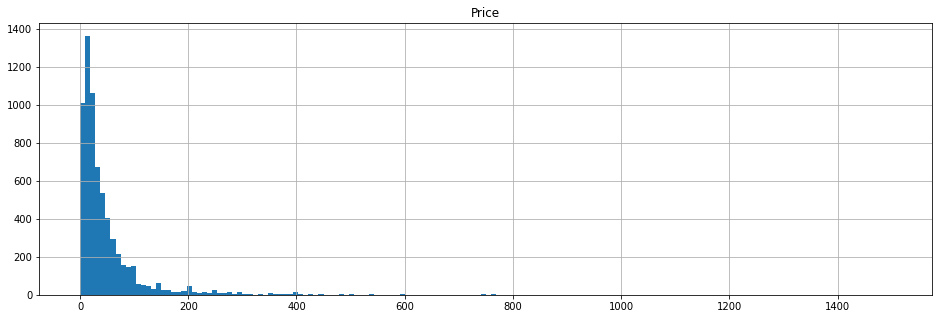

In [31]:
dfProd.hist(column='Price', bins=160, figsize=(16,5))

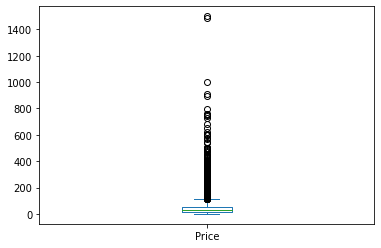

In [32]:
dfProd['Price'].plot.box()

## Reviews Data

### Data Cleaning

In [33]:
lenRevOrig = len(dfReviews)

In [34]:
# only keep reviews that has a valid product ASIN (ASIN exists in the products data)
dfReviews = dfReviews.loc[dfReviews['asin'].isin(dfProd['Asin'])]
lenRevClean = len(dfReviews)
print(str(lenRevOrig-lenRevClean), 'of', str(lenRevOrig), 'rows (', 
      '{:5.2f}'.format((lenRevOrig-lenRevClean)/lenRevOrig*100), ' %) are removed,',
      str(lenRevClean), 'remaining for analysis')

1079485 of 2565349 rows ( 42.08  %) are removed, 1485864 remaining for analysis


In [35]:
dfReviews['ReviewDate'] = pd.to_datetime(dfReviews['reviewTime'])

In [36]:
# convert vote to int
dfReviews['Vote'] = dfReviews['vote'].replace({',': ''}, regex=True)
dfReviews['Vote'] = dfReviews['Vote'].fillna(0)
dfReviews['Vote'] = dfReviews['Vote'].astype('float32').astype('Int32')

In [37]:
# rename overall to rating as it makes more sense and change data type to uint8 to save memory
dfReviews = dfReviews.rename(columns={'overall': 'Rating'})
dfReviews = dfReviews.astype({'Rating': np.uint8})

### Data Manipulation

#### Time

In [38]:
# compute review recentness
dfReviews['Recentness'] = ((dfReviews['ReviewDate'].max() + datetime.timedelta(days=1)) - dfReviews['ReviewDate']).dt.days
# dfReviews['recentness'] = (dfReviews['timeDiff'] / 90).astype(np.uint8) # 90 days = 3 months

In [39]:
# add dummy: whether before or after the ban of incentivized reviews (Oct 1, 2016)
dfReviews['IsAfterBan'] = dfReviews['ReviewDate'] >= pd.to_datetime('2016-10-01')

#### Style

In [40]:
# get style keys
dfReviewsStyle = dfReviews.loc[(~dfReviews['style'].isna())]

dfReviewsStyle['styleStr'] = [list(d.keys()) for d in dfReviewsStyle['style']]
dfReviewsStyle['styleStr'] = [','.join(map(str, l)) for l in dfReviewsStyle['styleStr']]
dfReviewsStyle['styleStr'] = dfReviewsStyle['styleStr'].replace({':': ''}, regex=True)
dfReviewsStyle = dfReviewsStyle[['styleStr']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [41]:
# merge with dfReviews
dfReviews = dfReviews.merge(dfReviewsStyle, how='left', left_index=True, right_index=True)
dfReviews['styleStr'] = dfReviews['styleStr'].fillna('')

In [42]:
# count number of styles
dfReviews['NumStyles'] = dfReviews['style'].str.len()
dfReviews['NumStyles'] = dfReviews['NumStyles'].fillna(0)

#### Sentiment Analysis

In [43]:
dfReviewsBackup = dfReviews.copy()

In [ ]:
# # code help: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook
# sia = SentimentIntensityAnalyzer()

# dfReviewsCopy = dfReviews.copy()
# dfReviewsCopy = dfReviewsCopy[['reviewText']]

# # get polarity score on dfMerged
# reviewPolarity = {}
# for i, row in dfReviewsCopy.iterrows():
#     text = str(row['reviewText'])
#     ps = sia.polarity_scores(text)
#     # ps['text'] = text
#     reviewPolarity[i] = ps
# dfReviewSia = pd.DataFrame(reviewPolarity).T

In [44]:
dfReviews = dfReviews.reset_index(drop=True)

dfReviewsSeries = dfReviews.copy()
dfReviewsSeries = dfReviewsSeries[['reviewText']]
dfReviewsSeries['reviewText'] = dfReviewsSeries['reviewText'].astype(str)
dfReviewsSeries = dfReviewsSeries['reviewText'].squeeze()

In [56]:
sia = SentimentIntensityAnalyzer()
npReviewPolarity = np.zeros(len(dfReviewsSeries))

In [57]:
# get polarity score
i = 0
for text in dfReviewsSeries:
  # ps = sia.polarity_scores(text)
  npReviewPolarity[i] = sia.polarity_scores(text)['compound']
  i += 1

In [61]:
dfReviewSia = pd.DataFrame(npReviewPolarity, columns=['Sentiment'])

In [64]:
# merge into dfReviews
dfReviews = dfReviews.merge(dfReviewSia, left_index=True, right_index=True)

#### Others

In [66]:
# count number of images
dfReviews['NumReviewImages'] = dfReviews['image'].str.len()
dfReviews['NumReviewImages'] = dfReviews['NumReviewImages'].fillna(0)

# count review summary and review text lengths
dfReviews['LenReviewText'] = dfReviews['reviewText'].str.len()
dfReviews['LenReviewText'] = dfReviews['LenReviewText'].fillna(0)
dfReviews['LenSummary'] = dfReviews['summary'].str.len()
dfReviews['LenSummary'] = dfReviews['LenSummary'].fillna(0)

In [71]:
# change data types of some columns and select only the useful columns before proceeding to the next step
dfReviews = dfReviews.astype({'NumReviewImages': np.uint8, 'LenReviewText': np.int32,
                              'LenSummary': np.int32, 'NumStyles': np.uint8})
dfReviews = dfReviews[['asin', 'Rating', 'verified', 'ReviewDate', 'Recentness', 'IsAfterBan',
                       'reviewerID', 'reviewText', 'LenReviewText', 'summary', 'LenSummary', 'Vote', 
                       'styleStr', 'NumStyles', 'NumReviewImages', 'Sentiment']]
dfReviews = dfReviews.rename(columns={'asin': 'Asin', 'verified': 'IsVerified', 'reviewerID': 'ReviewerId',
                                      'reviewText': 'ReviewText', 'summary': 'Summary', 'styleStr': 'Style'})

In [72]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485864 entries, 0 to 1485863
Data columns (total 16 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   Asin             1485864 non-null  object        
 1   Rating           1485864 non-null  uint8         
 2   IsVerified       1485864 non-null  bool          
 3   ReviewDate       1485864 non-null  datetime64[ns]
 4   Recentness       1485864 non-null  int64         
 5   IsAfterBan       1485864 non-null  bool          
 6   ReviewerId       1485864 non-null  object        
 7   ReviewText       1484921 non-null  object        
 8   LenReviewText    1485864 non-null  int32         
 9   Summary          1485469 non-null  object        
 10  LenSummary       1485864 non-null  int32         
 11  Vote             1485864 non-null  Int32         
 12  Style            1485864 non-null  object        
 13  NumStyles        1485864 non-null  uint8         
 14  Nu

In [73]:
dfReviews.describe(exclude='object', datetime_is_numeric=True)

,Rating,IsVerified,ReviewDate,Recentness,IsAfterBan,LenReviewText,LenSummary,Vote,NumStyles,NumReviewImages,Sentiment
count,1.485864e+06,1485864,1485864,1.485864e+06,1485864,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06
unique,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1015507,NaN,NaN,1269926,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.071494e+00,NaN,2013-03-03 07:22:43.163250688,2.039693e+03,NaN,4.756691e+02,2.275516e+01,1.801450e+00,7.889302e-01,1.029637e-02,5.239226e-01
min,1.000000e+00,NaN,1997-11-08 00:00:00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
25%,4.000000e+00,NaN,2011-05-19 00:00:00,9.950000e+02,NaN,5.600000e+01,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.446000e-01
50%,5.000000e+00,NaN,2014-07-17 00:00:00,1.539000e+03,NaN,1.640000e+02,1.600000e+01,0.000000e+00,1.000000e+00,0.000000e+00,7.163000e-01
75%,5.000000e+00,NaN,2016-01-12 00:00:00,2.694000e+03,NaN,4.770000e+02,3.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00,9.179000e-01
max,5.000000e+00,NaN,2018-10-02 00:00:00,7.634000e+03,NaN,3.272100e+04,3.000000e+02,5.154000e+03,3.000000e+00,4.800000e+01,1.000000e+00


In [74]:
dfReviews.head()

,Asin,Rating,IsVerified,ReviewDate,Recentness,IsAfterBan,ReviewerId,ReviewText,LenReviewText,Summary,LenSummary,Vote,Style,NumStyles,NumReviewImages,Sentiment
0,0439381673,1,True,2014-06-09,1577,False,A21ROB4YDOZA5P,I used to play this game years ago and loved i...,139,Did not like this,17,0,,0,0,0.7430
1,0439381673,3,True,2014-05-10,1607,False,A3TNZ2Q5E7HTHD,The game itself worked great but the story lin...,145,Almost Perfect,14,0,,0,0,0.3603
2,0439381673,4,True,2014-02-07,1699,False,A1OKRM3QFEATQO,I had to learn the hard way after ordering thi...,447,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,59,15,,0,0,0.7579
3,0439381673,1,True,2014-02-07,1699,False,A2XO1JFCNEYV3T,The product description should state this clea...,157,does not work on Mac OSX,24,11,,0,0,0.4810
4,0439381673,4,True,2014-01-16,1721,False,A19WLPIRHD15TH,I would recommend this learning game for anyon...,120,Roughing it,11,0,,0,0,0.8470


In [120]:
# save dfReviews to Drive for easier access later on
dfReviewsJson = dfReviews.copy()
dfReviewsJson['ReviewDate'] = dfReviewsJson['ReviewDate'].dt.strftime('%Y-%m-%d')
dfReviewsJson['Sentiment'] = dfReviewsJson['Sentiment'].round(4).astype(str)
dfReviewsJson.to_json('gdrive/MyDrive/amazon_data/clean_dfReviews.json', orient='split')

In [121]:
# how to retrieve the dfReviews json file
dfReviewsDrive = pd.read_json('gdrive/MyDrive/amazon_data/clean_dfReviews.json', orient='split')
dfReviewsDrive['ReviewDate'] = pd.to_datetime(dfReviewsDrive['ReviewDate'])

### Summary & Plots

In [125]:
# rating distribution by verified vs. unverified, and before vs. after ban
dfRevRatingDistbSum = pd.concat([dfReviews.groupby(['Rating', 'IsVerified']).size(),
                                 dfReviews.groupby(['Rating', 'IsAfterBan']).size()],
                                axis=1).unstack().reset_index()
dfRevRatingDistbSum = dfRevRatingDistbSum.rename(columns={0: 'Verification Status', 1: 'Before or After Ban'}, level=0)

# rating distribution of all samples
dfRevRatingDistb = dfReviews['Rating'].value_counts().sort_index().to_frame()
dfRevRatingDistb = dfRevRatingDistb.rename(columns={'Rating': 'Full Sample'})
dfRevRatingDistb.columns = pd.MultiIndex.from_product([dfRevRatingDistb.columns, ['Size']])
dfRevRatingDistb = dfRevRatingDistb.reset_index()
dfRevRatingDistb = dfRevRatingDistb.rename(columns={'index': 'Rating'})

dfRevRatingDistbSum = dfRevRatingDistb.merge(dfRevRatingDistbSum, on='Rating')

# calculate percentage
dfRevRatingDistbSum['Full Sample','Percentage'] = dfRevRatingDistbSum['Full Sample','Size']\
                                              /dfRevRatingDistbSum['Full Sample','Size'].sum()*100
dfRevRatingDistbSum['Verification Status', 'TruePercentage'] = dfRevRatingDistbSum['Verification Status', True]\
                                            /dfRevRatingDistbSum['Verification Status', True].sum()*100
dfRevRatingDistbSum['Verification Status', 'FalsePercentage'] = dfRevRatingDistbSum['Verification Status', False]\
                                            /dfRevRatingDistbSum['Verification Status', False].sum()*100
dfRevRatingDistbSum['Before or After Ban', 'TruePercentage'] = dfRevRatingDistbSum['Before or After Ban', True]\
                                            /dfRevRatingDistbSum['Before or After Ban', True].sum()*100
dfRevRatingDistbSum['Before or After Ban', 'FalsePercentage'] = dfRevRatingDistbSum['Before or After Ban', False]\
                                            /dfRevRatingDistbSum['Before or After Ban', False].sum()*100

dfRevRatingDistbSum = dfRevRatingDistbSum[['Rating', 'Full Sample', 'Verification Status', 'Before or After Ban']]
dfRevRatingDistbSum = dfRevRatingDistbSum.append(dfRevRatingDistbSum.sum(), ignore_index=True)
dfRevRatingDistbSum['Rating', ''][5] = ''

dfRevRatingDistbSum

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Rating Full Sample             Verification Status             \
                Size  Percentage               False       True   
0    1.0    163285.0   10.989229             68090.0    95195.0   
1    2.0     76056.0    5.118638             35024.0    41032.0   
2    3.0    124899.0    8.405816             48357.0    76542.0   
3    4.0    248527.0   16.726093             94991.0   153536.0   
4    5.0    873097.0   58.760223            223895.0   649202.0   
5          1485864.0  100.000000            470357.0  1015507.0   

                                 Before or After Ban                           \
  TruePercentage FalsePercentage               False      True TruePercentage   
0       9.374135       14.476238            135048.0   28237.0      13.076439   
1       4.040543        7.446259             67410.0    8646.0       4.003927   
2       7.537319       10.280914            111329.0   13570.0       6.284211   
3      15.119147       20.195511            224555.0   23972.0      11.101335   
4      63.928855       47.601077            731584.0  141513.0      65.534088   
5     100.000000      100.000000           1269926.0  215938.0     100.000000   

                   
  FalsePercentage  
0       10.634320  
1        5.308183  
2        8.766574  
3       17.682526  
4       57.608396  
5      100.000000

In [126]:
dfRevRatingDistbSum.to_latex(index=False, 
                             columns=[('Rating', ''), ('Full Sample', 'Percentage'),
                                      ('Verification Status', 'TruePercentage'), ('Verification Status', 'FalsePercentage'),
                                      ('Before or After Ban', 'TruePercentage'), ('Before or After Ban', 'FalsePercentage')],
                             float_format="{:0.2f}\%".format,
                             escape=False)

'\\begin{tabular}{lrrrrr}\n\\toprule\nRating & Full Sample & \\multicolumn{2}{l}{Verification Status} & \\multicolumn{2}{l}{Before or After Ban} \\\\\n       &  Percentage &      TruePercentage & FalsePercentage &      TruePercentage & FalsePercentage \\\\\n\\midrule\n1.00\\% &     10.99\\% &              9.37\\% &         14.48\\% &             13.08\\% &         10.63\\% \\\\\n2.00\\% &      5.12\\% &              4.04\\% &          7.45\\% &              4.00\\% &          5.31\\% \\\\\n3.00\\% &      8.41\\% &              7.54\\% &         10.28\\% &              6.28\\% &          8.77\\% \\\\\n4.00\\% &     16.73\\% &             15.12\\% &         20.20\\% &             11.10\\% &         17.68\\% \\\\\n5.00\\% &     58.76\\% &             63.93\\% &         47.60\\% &             65.53\\% &         57.61\\% \\\\\n       &    100.00\\% &            100.00\\% &        100.00\\% &            100.00\\% &        100.00\\% \\\\\n\\bottomrule\n\\end{tabular}\n'

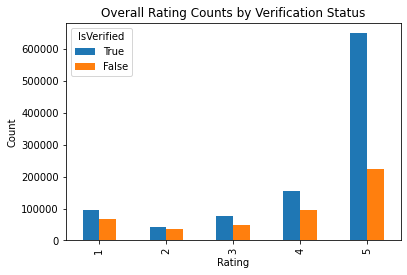

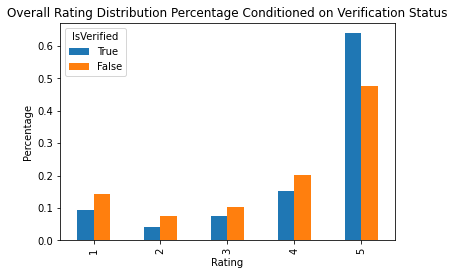

In [128]:
# rating distribution - graph
dfRatingsByVerified = dfReviews.groupby('IsVerified', sort=False).Rating.value_counts(normalize=False).unstack(0)
dfRatingsByVerified.plot.bar(xlabel='Rating', ylabel='Count', title='Overall Rating Counts by Verification Status')

dfRatingsByVerified = dfReviews.groupby('IsVerified', sort=False).Rating.value_counts(normalize=True).unstack(0)
dfRatingsByVerified.plot.bar(xlabel='Rating', ylabel='Percentage', 
                            title='Overall Rating Distribution Percentage Conditioned on Verification Status')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f963af28590>]],
      dtype=object)

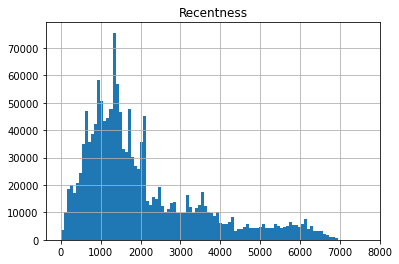

In [130]:
# review recentness
dfReviews.hist(column='Recentness', bins=100)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


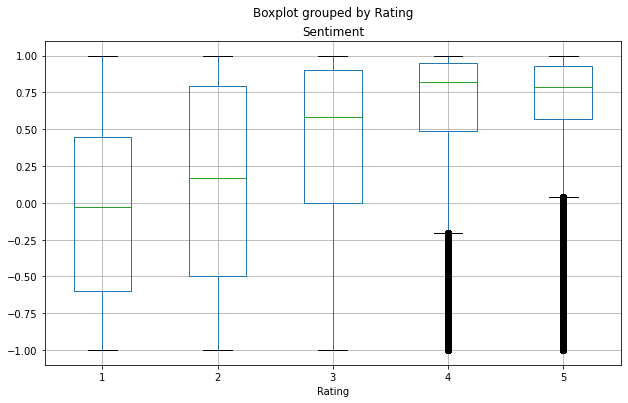

In [136]:
dfReviews.boxplot(column='Sentiment', by='Rating', figsize=(10,6)) #, flierprops=dict(markersize=3, marker='+')

## Merged Data

In [137]:
# merge reviews data and metadata together
dfMerged = dfReviews.merge(dfProd, how='inner', on='Asin')

In [138]:
dfMerged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1485864 entries, 0 to 1485863
Data columns (total 36 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Asin              1485864 non-null  object        
 1   Rating            1485864 non-null  uint8         
 2   IsVerified        1485864 non-null  bool          
 3   ReviewDate        1485864 non-null  datetime64[ns]
 4   Recentness        1485864 non-null  int64         
 5   IsAfterBan        1485864 non-null  bool          
 6   ReviewerId        1485864 non-null  object        
 7   ReviewText        1484921 non-null  object        
 8   LenReviewText     1485864 non-null  int32         
 9   Summary           1485469 non-null  object        
 10  LenSummary        1485864 non-null  int32         
 11  Vote              1485864 non-null  Int32         
 12  Style             1485864 non-null  object        
 13  NumStyles         1485864 non-null  uint8 

In [139]:
dfMerged.describe(exclude='object', datetime_is_numeric=True)

,Rating,IsVerified,ReviewDate,Recentness,IsAfterBan,LenReviewText,LenSummary,Vote,NumStyles,NumReviewImages,...,Price,RankVideoGames,RankCategory2,RankCategory3,RankCategory4,NumImages,NumHighResImages,NumDetails,LenFeature,LenDescription
count,1.485864e+06,1485864,1485864,1.485864e+06,1485864,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,...,131166.000000,1.485864e+06,1.457371e+06,231331.000000,122376.000000,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06
unique,NaN,2,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1015507,NaN,NaN,1269926,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.071494e+00,NaN,2013-03-03 07:22:43.163250944,2.039693e+03,NaN,4.756691e+02,2.275516e+01,1.801450e+00,7.889302e-01,1.029637e-02,...,72.214501,1.920373e+04,1.236860e+03,1322.184364,1867.057675,4.804897e+00,4.804897e+00,1.180794e-02,5.062602e+02,1.539573e+03
min,1.000000e+00,NaN,1997-11-08 00:00:00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.010000,2.000000e+00,1.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,NaN,2011-05-19 00:00:00,9.950000e+02,NaN,5.600000e+01,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,15.000000,3.978000e+03,1.120000e+02,75.000000,68.000000,1.000000e+00,1.000000e+00,0.000000e+00,1.660000e+02,4.150000e+02
50%,5.000000e+00,NaN,2014-07-17 00:00:00,1.539000e+03,NaN,1.640000e+02,1.600000e+01,0.000000e+00,1.000000e+00,0.000000e+00,...,28.900000,1.091800e+04,3.920000e+02,487.000000,521.000000,5.000000e+00,5.000000e+00,0.000000e+00,4.600000e+02,9.200000e+02
75%,5.000000e+00,NaN,2016-01-12 00:00:00,2.694000e+03,NaN,4.770000e+02,3.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00,...,66.940000,2.508500e+04,1.069000e+03,1478.000000,2322.000000,8.000000e+00,8.000000e+00,0.000000e+00,7.220000e+02,2.058000e+03
max,5.000000e+00,NaN,2018-10-02 00:00:00,7.634000e+03,NaN,3.272100e+04,3.000000e+02,5.154000e+03,3.000000e+00,4.800000e+01,...,1500.000000,2.417880e+05,5.106370e+05,509623.000000,186146.000000,1.400000e+01,1.400000e+01,7.000000e+00,7.993000e+03,1.878800e+04


### Aggregate Values

In [140]:
dfMergedMinTime = dfMerged.groupby(by=['Asin']).agg({'Recentness': 'max'}).reset_index()
dfMergedMinTime = dfMergedMinTime.rename(columns={'Recentness': 'MaxRecentness'})

In [143]:
dfMerged = dfMerged.merge(dfMergedMinTime, how='left', on='Asin')
dfMerged['MAXRecentness'] = dfMerged['Recentness'].max() + 1 
# MAXRecentness is absolute max recentness of all asin, MaxRecentness is local max recentness of each asin
dfMerged['ReverseRecentness'] = dfMerged['MAXRecentness'] - dfMerged['Recentness'] + 1
dfMerged['RatingByRecentness'] = dfMerged['ReverseRecentness'] * dfMerged['Rating']
dfMerged['SentimentByRecentness'] = dfMerged['ReverseRecentness'] * dfMerged['Sentiment']

In [146]:
dfAggr = dfMerged.groupby(['Asin'], as_index=False).agg({'Rating': 'mean', 
                                                         'ReviewerId': 'count', 
                                                         'IsVerified': [np.sum], 
                                                         'Vote': 'mean', 
                                                         'Sentiment': 'mean',
                                                        #  'NumStyles': 'mean', 
                                                         'NumReviewImages': 'mean',
                                                         'NumImages': 'min', 
                                                         'NumHighResImages': 'min',
                                                         'NumDetails': 'min',
                                                         'Price': 'min', 
                                                         'RankVideoGames': 'min',
                                                         'RatingByRecentness': 'mean', 
                                                         'SentimentByRecentness': 'mean'})
dfAggr.columns = ['_'.join(col).strip() for col in dfAggr.columns.values]

dfAggr = dfAggr.rename(columns={'Asin_': 'Asin', 'Rating_mean': 'MeanRating', 'ReviewerId_count': 'NumReviews',
                                'IsVerified_sum': 'NumVerifiedReviews', 'Vote_mean': 'MeanVote',
                                'Sentiment_mean': 'MeanSentiment',
                                # 'NumStyles_Mean': 'MeanNumStyles', 
                                'NumReviewImages_mean': 'MeanNumReviewImages',
                                'NumImages_min': 'NumImages', 'NumHighResImages_min': 'NumHighResImages',
                                'NumDetails_min': 'NumDetails', 'Price_min': 'Price', 
                                'RankVideoGames_min': 'RankVideoGames', 
                                'RatingByRecentness_mean': 'MeanRatingByRecentness',
                                'SentimentByRecentness_mean': 'MeanSentimentByRecentness'})

In [162]:
dfAggr = dfAggr.astype({'MeanVote': np.float64, 'RankVideoGames': np.int64})

In [163]:
dfAggr.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39990 entries, 0 to 39989
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Asin                       39990 non-null  object 
 1   MeanRating                 39990 non-null  float64
 2   NumReviews                 39990 non-null  int64  
 3   NumVerifiedReviews         39990 non-null  int64  
 4   MeanVote                   39990 non-null  float64
 5   MeanSentiment              39990 non-null  float64
 6   MeanNumReviewImages        39990 non-null  float64
 7   NumImages                  39990 non-null  uint8  
 8   NumHighResImages           39990 non-null  uint8  
 9   NumDetails                 39990 non-null  uint8  
 10  Price                      6632 non-null   float64
 11  RankVideoGames             39990 non-null  int64  
 12  MeanRatingByRecentness     39990 non-null  float64
 13  MeanSentimentByRecentness  39990 non-null  flo

### Verified Purchases

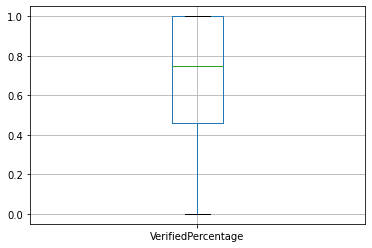

In [148]:
dfAggr['VerifiedPercentage'] = dfAggr['NumVerifiedReviews'] / dfAggr['NumReviews']
dfAggr.boxplot(column='VerifiedPercentage')

### Mean Product Rating vs. Number of Reviews

In [149]:
# get mean rating and total counts per asin per verified
gcAsinVer = dfMerged.groupby(['Asin', 'IsVerified'], as_index=False).agg({'Rating': 'mean', 'ReviewerId': 'count'})
gcAsinVer = gcAsinVer.rename(columns={'Rating': 'MeanRating', 'ReviewerId': 'NumReviews'})
# gcAsinVer = gcAsinVer.sort_values(by=['NumReviews', 'asin', 'verified'], ascending=[False, True, True], ignore_index=True)

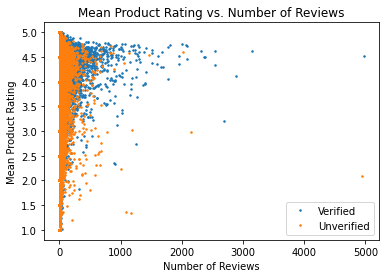

In [150]:
# plot scatterplot of ratings vs. number of reviews per product for verified and unverified reviews respectively
gcVerified = gcAsinVer.loc[gcAsinVer['IsVerified'] == True]
gcUnverified = gcAsinVer.loc[gcAsinVer['IsVerified'] == False]

plt.figure()
plt.plot(gcVerified['NumReviews'], gcVerified['MeanRating'], '.', markersize=3, label='Verified')
plt.plot(gcUnverified['NumReviews'], gcUnverified['MeanRating'], '.', markersize=3, label='Unverified')
plt.title('Mean Product Rating vs. Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Mean Product Rating')
plt.legend()
plt.show()

### Correlation & Multicollinearity

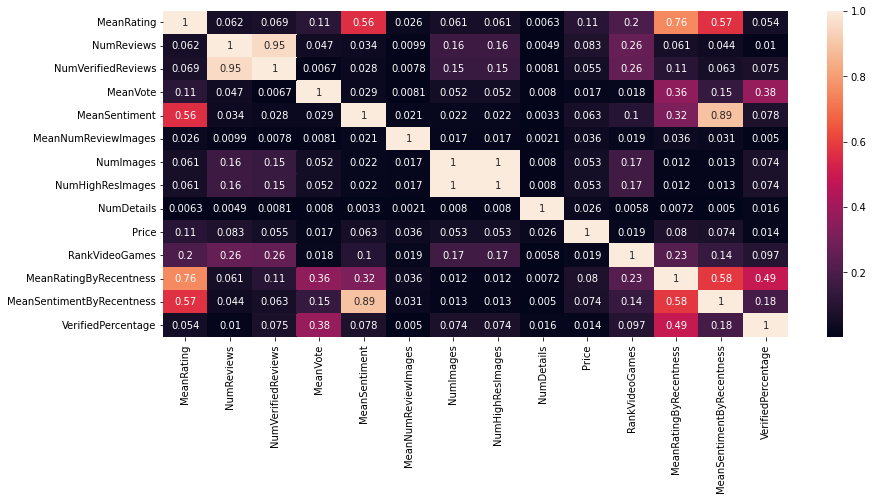

In [164]:
dfAggrCorr = dfAggr.corr()
dfAggrCorr = dfAggrCorr.abs()

plt.figure(figsize=(14, 6))
sns.heatmap(dfAggrCorr, annot=True)

In [ ]:
# multicollinearity


### Regression Model

In [165]:
from statsmodels.formula.api import ols
regResult = ols(formula="RankVideoGames ~ MeanRating + NumReviews + VerifiedPercentage + \
                          MeanVote + MeanRatingByRecentness + MeanSentimentByRecentness",
                data=dfAggr).fit() # homogeneous regression

In [166]:
regResult.params

Intercept                    111471.435271
MeanRating                    -2865.819987
NumReviews                      -92.214675
VerifiedPercentage            -5677.823045
MeanVote                      -2046.312098
MeanRatingByRecentness           -1.146825
MeanSentimentByRecentness         0.030298
dtype: float64

In [167]:
regResult.summary()#.as_latex()
# for table in results.summary().tables:
    # print(table.as_latex_tabular())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     944.1
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:05:40   Log-Likelihood:            -4.8655e+05
No. Observations:               39990   AIC:                         9.731e+05
Df Residuals:                   39983   BIC:                         9.732e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.115e+05   1205.920     92.437      0.000    1.09e+05    1.14e+05
MeanRating                -2865.8200    436.396     -6.567      0.000   -3721.166   -2010.474
NumReviews                  -92.2147      1.767    -52.178      0.000     -95.679     -88.751
VerifiedPercentage        -5677.8230    990.889     -5.730      0.000   -7619.988   -3735.658
MeanVote                  -2046.3121    114.192    -17.920      0.000   -2270.131   -1822.493
MeanRatingByRecentness       -1.1468      0.065    -17.735      0.000      -1.274      -1.020
MeanSentimentByRecentness     0.0303      0.156      0.194      0.846      -0.276       0.337
==============================================================================
Omnibus:                     8624.116   Durbin-Watson:                   1.509
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19184.085
Skew:                           1.239   Prob(JB):                         0.00
Kurtosis:                       5.317   Cond. No.                     1.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
heterogeneityReg = sm.ols(formula="rankVideoGames ~ rating_mean + reviews_count + verified_percentage + \
                            vote_mean + recentRating_mean + recentCompound_mean + \
                            numImages + numHighResImages + numDetails",
                   data=dfAggr).fit() # heterogeneity test

In [ ]:
heterogeneityReg.params

Intercept              135990.543652
rating_mean             -5388.343483
reviews_count             -74.529485
verified_percentage    -25457.210531
vote_mean                -857.041681
recentRating_mean        -529.170429
recentCompound_mean      -285.912891
numImages                7520.944452
numHighResImages        -2579.023206
numDetails              -1540.278291
dtype: float64

In [ ]:
heterogeneityReg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rankVideoGames   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     1675.
Date:                Mon, 31 Oct 2022   Prob (F-statistic):               0.00
Time:                        04:13:30   Log-Likelihood:            -4.9453e+05
No. Observations:               40941   AIC:                         9.891e+05
Df Residuals:                   40931   BIC:                         9.892e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             1.36e+05   1029.746    132.062      0.000    1.34e+05    1.38e+05
rating_mean         -5388.3435    218.840    -24.622      0.000   -5817.274   -4959.413
reviews_count         -74.5295      1.567    -47.561      0.000     -77.601     -71.458
verified_percentage -2.546e+04    713.704    -35.669      0.000   -2.69e+04   -2.41e+04
vote_mean            -857.0417     98.940     -8.662      0.000   -1050.967    -663.116
recentRating_mean    -529.1704     10.604    -49.905      0.000    -549.954    -508.387
recentCompound_mean  -285.9129     57.088     -5.008      0.000    -397.807    -174.019
numImages            7520.9445   1426.677      5.272      0.000    4724.626    1.03e+04
numHighResImages    -2579.0232     70.090    -36.796      0.000   -2716.402   -2441.644
numDetails          -1540.2783   1004.405     -1.534      0.125   -3508.934     428.378
==============================================================================
Omnibus:                     5969.131   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10385.494
Skew:                           0.962   Prob(JB):                         0.00
Kurtosis:                       4.544   Cond. No.                         968.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""